In [2]:
import pandas as pd

# Load data
df_2024 = pd.read_csv("FantasyData2024_clean.csv")
df_2023 = pd.read_csv("FantasyData2023_clean.csv")

# Filter WR and RB groups
wr_2024 = df_2024[df_2024["FantPos"] == "WR"].copy()
rb_2024 = df_2024[df_2024["FantPos"] == "RB"].copy()
wr_2023 = df_2023[df_2023["FantPos"] == "WR"].copy()
rb_2023 = df_2023[df_2023["FantPos"] == "RB"].copy()


Analyzing WR Position


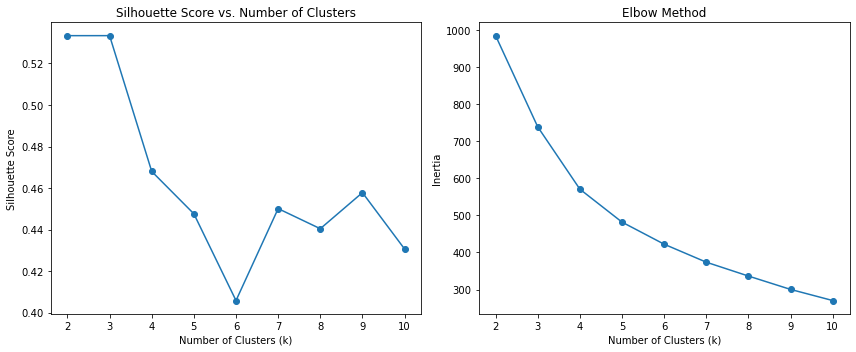


Optimal number of clusters for WR: 3


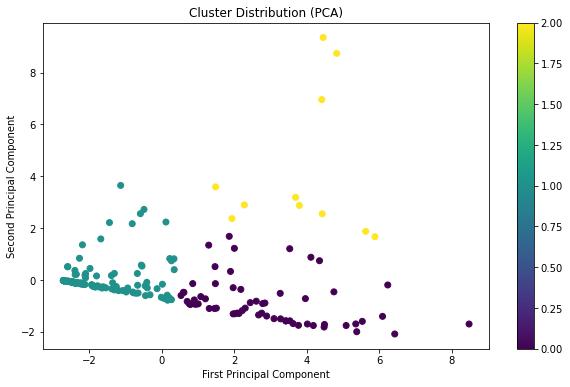

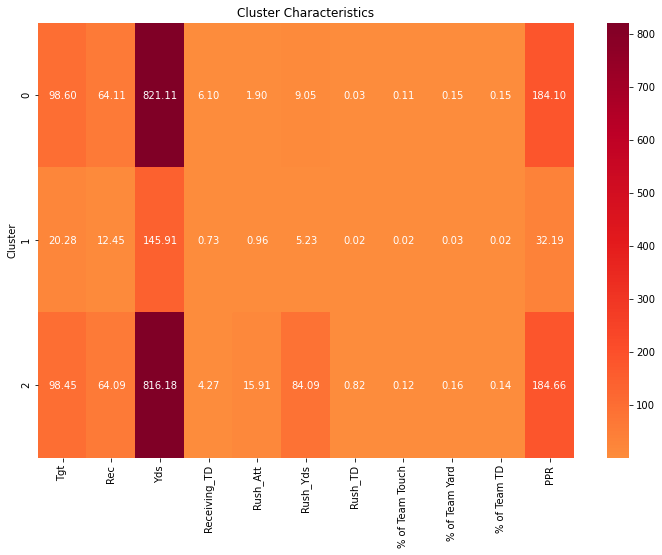


Cluster Sizes:
Cluster
0     62
1    128
2     11
Name: count, dtype: int64

Average PPR by Cluster:
Cluster
2    184.663636
0    184.101613
1     32.188281
Name: PPR, dtype: float64

Feature Correlations with PPR:
Yds                0.990226
Rec                0.979287
% of Team Yard     0.976821
Tgt                0.973023
% of Team Touch    0.961554
Receiving_TD       0.897958
% of Team TD       0.896852
Rush_Yds           0.304929
Rush_Att           0.303518
Rush_TD            0.172068
dtype: float64

Analyzing RB Position


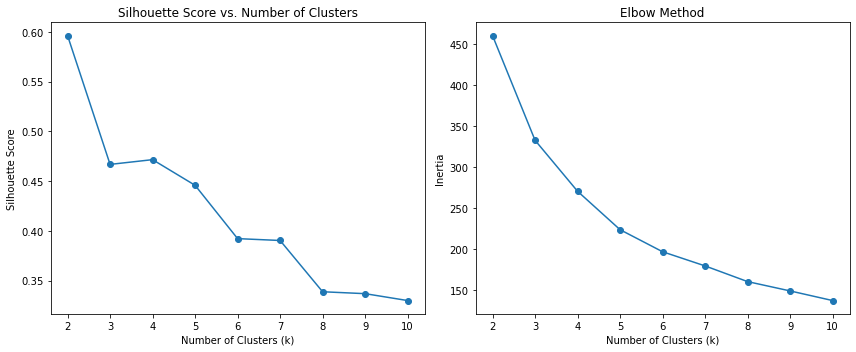


Optimal number of clusters for RB: 2


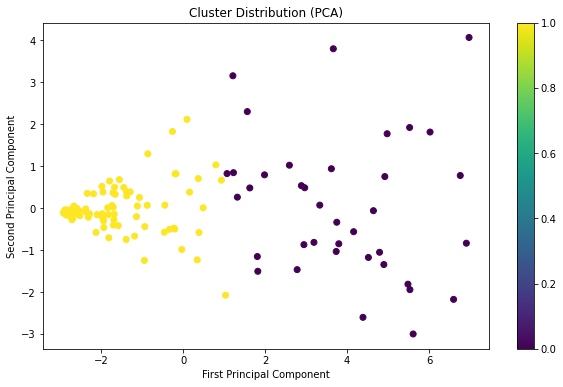

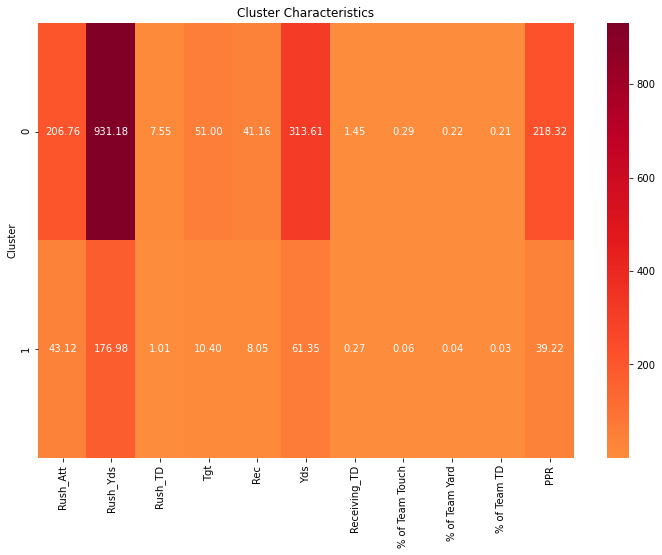


Cluster Sizes:
Cluster
0    38
1    88
Name: count, dtype: int64

Average PPR by Cluster:
Cluster
0    218.323684
1     39.219318
Name: PPR, dtype: float64

Feature Correlations with PPR:
% of Team Yard     0.970578
% of Team Touch    0.960078
Rush_Yds           0.955319
Rush_Att           0.952453
% of Team TD       0.919240
Rush_TD            0.902854
Rec                0.867438
Tgt                0.864088
Yds                0.849884
Receiving_TD       0.585177
dtype: float64


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. First, let's prepare our features for WRs and RBs separately
def prepare_position_data(df, position):
    position_df = df[df['FantPos'] == position].copy()
    
    # Select relevant features for analysis
    if position == 'WR':
        features = ['Tgt', 'Rec', 'Yds', 'Receiving_TD', 'Rush_Att', 'Rush_Yds', 
                   'Rush_TD', '% of Team Touch', '% of Team Yard', '% of Team TD']
    else:  # RB
        features = ['Rush_Att', 'Rush_Yds', 'Rush_TD', 'Tgt', 'Rec', 'Yds',
                   'Receiving_TD', '% of Team Touch', '% of Team Yard', '% of Team TD']
    
    # Create feature matrix
    X = position_df[features].copy()
    y = position_df['PPR']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, X, y, position_df, features

# 2. Function to determine optimal number of clusters
def find_optimal_clusters(X, max_clusters=10):
    silhouette_scores = []
    inertias = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, clusters))
        inertias.append(kmeans.inertia_)
    
    # Plot silhouette scores
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    
    # Plot elbow curve
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.tight_layout()
    plt.show()
    
    return silhouette_scores, inertias

# 3. Function to analyze clusters
def analyze_clusters(X, X_raw, y, features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Create DataFrame with clusters and PPR
    cluster_df = pd.DataFrame(X_raw, columns=features)
    cluster_df['Cluster'] = clusters
    cluster_df['PPR'] = y
    
    # Calculate cluster means
    cluster_means = cluster_df.groupby('Cluster').mean()
    
    # Visualize clusters using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(f'Cluster Distribution (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()
    
    # Feature importance heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_means, cmap='YlOrRd', annot=True, fmt='.2f', center=0)
    plt.title('Cluster Characteristics')
    plt.show()
    
    return cluster_df, cluster_means

# Let's analyze both positions
for position in ['WR', 'RB']:
    print(f"\n{'='*50}")
    print(f"Analyzing {position} Position")
    print(f"{'='*50}")
    
    # Prepare data
    X_scaled, X_raw, y, position_df, features = prepare_position_data(df_2024, position)
    
    # Find optimal clusters
    silhouette_scores, inertias = find_optimal_clusters(X_scaled)
    
    # Choose optimal number of clusters based on silhouette score
    optimal_clusters = np.argmax(silhouette_scores) + 2
    print(f"\nOptimal number of clusters for {position}: {optimal_clusters}")
    
    # Analyze clusters
    cluster_df, cluster_means = analyze_clusters(X_scaled, X_raw, y, features, optimal_clusters)
    
    # Print cluster characteristics
    print("\nCluster Sizes:")
    print(cluster_df['Cluster'].value_counts().sort_index())
    
    print("\nAverage PPR by Cluster:")
    print(cluster_df.groupby('Cluster')['PPR'].mean().sort_values(ascending=False))
    
    # Correlation with PPR
    correlations = cluster_df[features].corrwith(cluster_df['PPR']).sort_values(ascending=False)
    print("\nFeature Correlations with PPR:")
    print(correlations)




=== TEAM OFFENSIVE ENVIRONMENT ANALYSIS ===

TOP OFFENSIVE ENVIRONMENTS (2024):

DET:
Plays/Game: 63.7
Pass Rate: 50.8%
Yards/Play: 6.6
PPR/Play: 1.70

TAM:
Plays/Game: 61.6
Pass Rate: 54.4%
Yards/Play: 6.7
PPR/Play: 1.68

WAS:
Plays/Game: 61.8
Pass Rate: 50.0%
Yards/Play: 6.2
PPR/Play: 1.51

BAL:
Plays/Game: 60.6
Pass Rate: 46.3%
Yards/Play: 7.2
PPR/Play: 1.69

BUF:
Plays/Game: 59.5
Pass Rate: 51.4%
Yards/Play: 6.1
PPR/Play: 1.50

CIN:
Plays/Game: 58.9
Pass Rate: 65.1%
Yards/Play: 6.4
PPR/Play: 1.74

PHI:
Plays/Game: 62.9
Pass Rate: 41.9%
Yards/Play: 6.1
PPR/Play: 1.40

GNB:
Plays/Game: 59.1
Pass Rate: 47.7%
Yards/Play: 6.4
PPR/Play: 1.49

MIN:
Plays/Game: 55.4
Pass Rate: 58.2%
Yards/Play: 6.3
PPR/Play: 1.55

SFO:
Plays/Game: 58.1
Pass Rate: 53.9%
Yards/Play: 6.7
PPR/Play: 1.48

TEAMS TRENDING UP (Based on 2023-2024 Changes):

TAM:
Play Volume Change: 39.4/game
Efficiency Change: 3.15 yards/play
Pass Rate Change: 54.2%

BAL:
Play Volume Change: 38.5/game
Efficiency Change: 2.42 yards

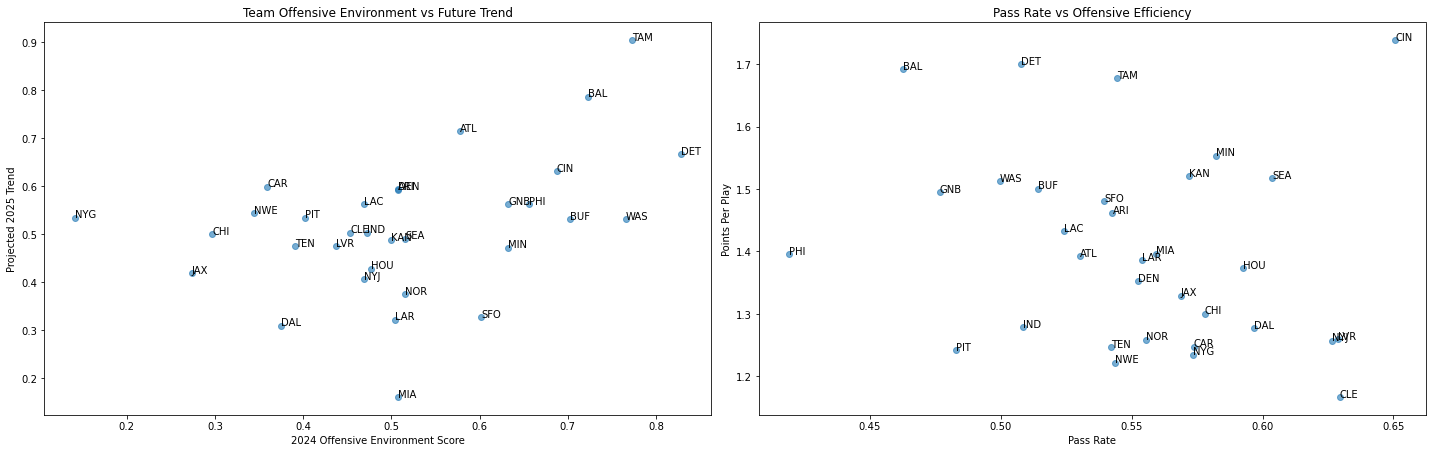


=== PLAYER VALUE IN TEAM CONTEXT ===

HIGH-VALUE PLAYERS IN STRONG OFFENSES:

WRs:

Ja'Marr Chase (CIN):
Team Offense Ranking: 0.69
Usage: 19.0% of team touches
TD Share: 31.0% of team TDs
Context Value Score: 0.38

Terry McLaurin (WAS):
Team Offense Ranking: 0.77
Usage: 14.0% of team touches
TD Share: 25.0% of team TDs
Context Value Score: 0.36

Amon-Ra St. Brown (DET):
Team Offense Ranking: 0.83
Usage: 14.0% of team touches
TD Share: 18.0% of team TDs
Context Value Score: 0.36

Justin Jefferson (MIN):
Team Offense Ranking: 0.63
Usage: 19.0% of team touches
TD Share: 24.0% of team TDs
Context Value Score: 0.34

Mike Evans (TAM):
Team Offense Ranking: 0.77
Usage: 11.0% of team touches
TD Share: 19.0% of team TDs
Context Value Score: 0.33

Jameson Williams (DET):
Team Offense Ranking: 0.83
Usage: 10.0% of team touches
TD Share: 12.0% of team TDs
Context Value Score: 0.32

Tee Higgins (CIN):
Team Offense Ranking: 0.69
Usage: 12.0% of team touches
TD Share: 19.0% of team TDs
Context Valu

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_team_offenses(df_2023, df_2024):
    def aggregate_team_stats(df):
        return df.groupby('Tm').agg({
            'Team Tuches': 'first',  # Total team touches
            'Team Yard': 'first',    # Total team yards
            'Team TD': 'first',      # Total team TDs
            'Pass_Att': 'sum',       # Total pass attempts
            'Rush_Att': 'sum',       # Total rush attempts
            'Pass_Yds': 'sum',       # Total passing yards
            'Rush_Yds': 'sum',       # Total rushing yards
            'Pass_TD': 'sum',        # Total passing TDs
            'Rush_TD': 'sum',        # Total rushing TDs
            'Tgt': 'sum',            # Total targets
            'PPR': 'sum'             # Total PPR points generated
        }).assign(
            Plays_Per_Game=lambda x: (x['Pass_Att'] + x['Rush_Att']) / 17,
            Yards_Per_Play=lambda x: (x['Pass_Yds'] + x['Rush_Yds']) / (x['Pass_Att'] + x['Rush_Att']),
            Pass_Rate=lambda x: x['Pass_Att'] / (x['Pass_Att'] + x['Rush_Att']),
            Points_Per_Play=lambda x: x['PPR'] / (x['Pass_Att'] + x['Rush_Att']),
            Red_Zone_TD_Rate=lambda x: (x['Pass_TD'] + x['Rush_TD']) / x['Team TD']
        )

    # Aggregate stats for both years
    team_stats_2023 = aggregate_team_stats(df_2023)
    team_stats_2024 = aggregate_team_stats(df_2024)

    # Calculate year-over-year changes
    team_trends = pd.merge(team_stats_2023, team_stats_2024,
                          left_index=True, right_index=True,
                          suffixes=('_2023', '_2024'))
    
    # Calculate trending metrics
    team_trends['Play_Volume_Change'] = team_trends['Plays_Per_Game_2024'] - team_trends['Plays_Per_Game_2023']
    team_trends['Efficiency_Change'] = team_trends['Yards_Per_Play_2024'] - team_trends['Yards_Per_Play_2023']
    team_trends['Pass_Rate_Change'] = team_trends['Pass_Rate_2024'] - team_trends['Pass_Rate_2023']
    team_trends['PPR_Change'] = team_trends['Points_Per_Play_2024'] - team_trends['Points_Per_Play_2023']
    
    return team_trends

def project_team_environments(team_trends):
    # Create a team environment score based on key metrics
    team_trends['Offense_Score_2024'] = (
        team_trends['Plays_Per_Game_2024'].rank(pct=True) * 0.25 +
        team_trends['Yards_Per_Play_2024'].rank(pct=True) * 0.25 +
        team_trends['Points_Per_Play_2024'].rank(pct=True) * 0.25 +
        team_trends['Red_Zone_TD_Rate_2024'].rank(pct=True) * 0.25
    )
    
    # Project 2025 trend based on 2023-2024 trajectory
    team_trends['Projected_Trend'] = (
        team_trends['Play_Volume_Change'].rank(pct=True) * 0.3 +
        team_trends['Efficiency_Change'].rank(pct=True) * 0.3 +
        team_trends['PPR_Change'].rank(pct=True) * 0.4
    )
    
    return team_trends

def print_team_analysis(team_trends):
    print("\n=== TEAM OFFENSIVE ENVIRONMENT ANALYSIS ===")
    
    # High-powered offenses
    print("\nTOP OFFENSIVE ENVIRONMENTS (2024):")
    print("=================================")
    top_offenses = team_trends.nlargest(10, 'Offense_Score_2024')
    for team in top_offenses.index:
        print(f"\n{team}:")
        print(f"Plays/Game: {team_trends.loc[team, 'Plays_Per_Game_2024']:.1f}")
        print(f"Pass Rate: {team_trends.loc[team, 'Pass_Rate_2024']:.1%}")
        print(f"Yards/Play: {team_trends.loc[team, 'Yards_Per_Play_2024']:.1f}")
        print(f"PPR/Play: {team_trends.loc[team, 'Points_Per_Play_2024']:.2f}")
    
    # Trending Up
    print("\nTEAMS TRENDING UP (Based on 2023-2024 Changes):")
    print("============================================")
    trending_up = team_trends.nlargest(5, 'Projected_Trend')
    for team in trending_up.index:
        print(f"\n{team}:")
        print(f"Play Volume Change: {team_trends.loc[team, 'Play_Volume_Change']:.1f}/game")
        print(f"Efficiency Change: {team_trends.loc[team, 'Efficiency_Change']:.2f} yards/play")
        print(f"Pass Rate Change: {team_trends.loc[team, 'Pass_Rate_Change']:.1%}")
    
    # Fantasy Friendly Environments
    print("\nBEST FANTASY ENVIRONMENTS (2025 Projection):")
    print("=========================================")
    fantasy_friendly = team_trends.nlargest(8, 'Offense_Score_2024')
    for team in fantasy_friendly.index:
        print(f"\n{team}:")
        print("Offensive Metrics:")
        print(f"- Total Plays/Game: {team_trends.loc[team, 'Plays_Per_Game_2024']:.1f}")
        print(f"- Pass Rate: {team_trends.loc[team, 'Pass_Rate_2024']:.1%}")
        print(f"- Red Zone TD Rate: {team_trends.loc[team, 'Red_Zone_TD_Rate_2024']:.1%}")
        print(f"Trend Direction: {'↑' if team_trends.loc[team, 'Projected_Trend'] > 0.5 else '↓'}")

def visualize_team_trends(team_trends):
    # Create visualizations
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Offensive Environment Score vs Projected Trend
    plt.subplot(2, 2, 1)
    plt.scatter(team_trends['Offense_Score_2024'], 
               team_trends['Projected_Trend'],
               alpha=0.6)
    for team in team_trends.index:
        plt.annotate(team, (team_trends.loc[team, 'Offense_Score_2024'],
                          team_trends.loc[team, 'Projected_Trend']))
    plt.xlabel('2024 Offensive Environment Score')
    plt.ylabel('Projected 2025 Trend')
    plt.title('Team Offensive Environment vs Future Trend')
    
    # Plot 2: Pass Rate vs Points Per Play
    plt.subplot(2, 2, 2)
    plt.scatter(team_trends['Pass_Rate_2024'],
               team_trends['Points_Per_Play_2024'],
               alpha=0.6)
    for team in team_trends.index:
        plt.annotate(team, (team_trends.loc[team, 'Pass_Rate_2024'],
                          team_trends.loc[team, 'Points_Per_Play_2024']))
    plt.xlabel('Pass Rate')
    plt.ylabel('Points Per Play')
    plt.title('Pass Rate vs Offensive Efficiency')
    
    plt.tight_layout()
    plt.show()

def analyze_player_in_context(df_2024, team_trends):
    print("\n=== PLAYER VALUE IN TEAM CONTEXT ===")
    
    # Combine player stats with team environment
    players_in_context = pd.merge(
        df_2024,
        team_trends[['Offense_Score_2024', 'Projected_Trend']],
        left_on='Tm',
        right_index=True
    )
    
    # Calculate contextual value score
    players_in_context['Context_Value_Score'] = (
        (players_in_context['% of Team Touch'] * 0.4) +
        (players_in_context['% of Team TD'] * 0.3) +
        (players_in_context['Offense_Score_2024'] * 0.3)
    )
    
    # Print high-value players in good offenses
    print("\nHIGH-VALUE PLAYERS IN STRONG OFFENSES:")
    print("=====================================")
    
    for pos in ['WR', 'RB']:
        print(f"\n{pos}s:")
        pos_players = players_in_context[players_in_context['FantPos'] == pos]
        high_value = pos_players.nlargest(10, 'Context_Value_Score')
        
        for _, player in high_value.iterrows():
            print(f"\n{player['Player']} ({player['Tm']}):")
            print(f"Team Offense Ranking: {player['Offense_Score_2024']:.2f}")
            print(f"Usage: {player['% of Team Touch']:.1%} of team touches")
            print(f"TD Share: {player['% of Team TD']:.1%} of team TDs")
            print(f"Context Value Score: {player['Context_Value_Score']:.2f}")

# Execute the analysis
team_trends = analyze_team_offenses(df_2023, df_2024)
team_trends = project_team_environments(team_trends)
print_team_analysis(team_trends)
visualize_team_trends(team_trends)
analyze_player_in_context(df_2024, team_trends)

# Additional analysis for fantasy draft strategy
def generate_offense_adjusted_rankings(df_2024, team_trends):
    # Combine player stats with team context
    adjusted_rankings = pd.merge(
        df_2024,
        team_trends[['Offense_Score_2024', 'Projected_Trend', 'Pass_Rate_2024']],
        left_on='Tm',
        right_index=True
    )
    
    # Calculate position-specific opportunity scores
    adjusted_rankings['Opportunity_Score'] = np.where(
        adjusted_rankings['FantPos'] == 'WR',
        adjusted_rankings['Pass_Rate_2024'] * adjusted_rankings['% of Team Touch'],
        (1 - adjusted_rankings['Pass_Rate_2024']) * adjusted_rankings['% of Team Touch']
    )
    
    # Calculate adjusted value score
    adjusted_rankings['Adjusted_Value'] = (
        adjusted_rankings['PPR'] * 0.4 +
        (adjusted_rankings['Opportunity_Score'] * adjusted_rankings['Offense_Score_2024']) * 0.4 +
        (adjusted_rankings['% of Team TD'] * adjusted_rankings['Offense_Score_2024']) * 0.2
    )
    
    return adjusted_rankings.sort_values('Adjusted_Value', ascending=False)

# Print offense-adjusted rankings
adj_rankings = generate_offense_adjusted_rankings(df_2024, team_trends)

print("\n=== OFFENSE-ADJUSTED PLAYER RANKINGS ===")
for pos in ['WR', 'RB']:
    print(f"\nTop {pos}s (Adjusted for Team Offense):")
    pos_rankings = adj_rankings[adj_rankings['FantPos'] == pos].head(15)
    for _, player in pos_rankings.iterrows():
        print(f"\n{player['Player']} ({player['Tm']}):")
        print(f"Raw PPR: {player['PPR']:.1f}")
        print(f"Adjusted Value: {player['Adjusted_Value']:.1f}")
        print(f"Team Offense Score: {player['Offense_Score_2024']:.2f}")
        print(f"Opportunity Score: {player['Opportunity_Score']:.2f}")


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Enable offline mode for Plotly
pio.renderers.default = "browser"

def analyze_team_trends(df_2023, df_2024):
    # Aggregate data at team level
    team_stats_2023 = aggregate_team_stats(df_2023)
    team_stats_2024 = aggregate_team_stats(df_2024)
    
    # Merge team data
    team_trends = pd.merge(team_stats_2023, team_stats_2024, 
                          on='Team', 
                          suffixes=('_2023', '_2024'))
    
    # Calculate year-over-year changes
    team_trends['Yards_Change'] = team_trends['Total_Yards_2024'] - team_trends['Total_Yards_2023']
    team_trends['Yards_Change_Pct'] = team_trends['Yards_Change'] / team_trends['Total_Yards_2023']
    team_trends['TD_Change'] = team_trends['Total_TD_2024'] - team_trends['Total_TD_2023']
    team_trends['Pass_Ratio_Change'] = team_trends['Pass_Ratio_2024'] - team_trends['Pass_Ratio_2023']
    team_trends['Fantasy_Points_Change'] = team_trends['Fantasy_Points_2024'] - team_trends['Fantasy_Points_2023']
    
    # Calculate projected 2025 values (basic projection with trend continuation)
    team_trends['Projected_Yards_2025'] = team_trends['Total_Yards_2024'] + team_trends['Yards_Change']
    team_trends['Projected_TD_2025'] = team_trends['Total_TD_2024'] + team_trends['TD_Change']
    team_trends['Projected_Pass_Ratio_2025'] = team_trends['Pass_Ratio_2024'] + (team_trends['Pass_Ratio_Change'] * 0.5)  # Dampen the trend
    team_trends['Projected_Fantasy_Points_2025'] = team_trends['Fantasy_Points_2024'] + team_trends['Fantasy_Points_Change']
    
    # Add momentum score (composite metric of key growth indicators)
    team_trends['Offensive_Momentum'] = (
        team_trends['Yards_Change_Pct'].rank(pct=True) +
        team_trends['TD_Change'].rank(pct=True) +
        team_trends['Fantasy_Points_Change'].rank(pct=True)
    ) / 3
    
    return team_trends

def aggregate_team_stats(df):
    # Group by team
    team_stats = df.groupby('Tm').agg({
        'Player': 'count',
        'Yds': 'sum',  # Receiving yards
        'Rush_Yds': 'sum',
        'Receiving_TD': 'sum',
        'Rush_TD': 'sum',
        'Pass_Yds': 'sum',
        'Pass_TD': 'sum',
        'Pass_Att': 'sum',
        'Rush_Att': 'sum',
        'PPR': 'sum'  # Total fantasy points
    }).reset_index()
    
    # Rename team column
    team_stats = team_stats.rename(columns={'Tm': 'Team'})
    
    # Calculate total yards and TDs
    team_stats['Total_Yards'] = team_stats['Yds'] + team_stats['Rush_Yds'] + team_stats['Pass_Yds']
    team_stats['Total_TD'] = team_stats['Receiving_TD'] + team_stats['Rush_TD'] + team_stats['Pass_TD']
    
    # Calculate pass ratio
    team_stats['Total_Plays'] = team_stats['Pass_Att'] + team_stats['Rush_Att']
    team_stats['Pass_Ratio'] = team_stats['Pass_Att'] / team_stats['Total_Plays']
    
    # Rename PPR to Fantasy_Points for clarity
    team_stats['Fantasy_Points'] = team_stats['PPR']
    
    return team_stats

def classify_team_environments(team_trends):
    # Create classification for team environments
    conditions = [
        # High volume passing offenses growing
        (team_trends['Pass_Ratio_2024'] > 0.58) & (team_trends['Offensive_Momentum'] > 0.6),
        # High volume passing offenses declining
        (team_trends['Pass_Ratio_2024'] > 0.58) & (team_trends['Offensive_Momentum'] < 0.4),
        # Balanced offenses growing
        (team_trends['Pass_Ratio_2024'].between(0.52, 0.58)) & (team_trends['Offensive_Momentum'] > 0.6),
        # Balanced offenses declining
        (team_trends['Pass_Ratio_2024'].between(0.52, 0.58)) & (team_trends['Offensive_Momentum'] < 0.4),
        # Run-heavy offenses growing
        (team_trends['Pass_Ratio_2024'] < 0.52) & (team_trends['Offensive_Momentum'] > 0.6),
        # Run-heavy offenses declining
        (team_trends['Pass_Ratio_2024'] < 0.52) & (team_trends['Offensive_Momentum'] < 0.4)
    ]
    
    choices = [
        'High-Pass Growing',
        'High-Pass Declining',
        'Balanced Growing',
        'Balanced Declining',
        'Run-Heavy Growing',
        'Run-Heavy Declining'
    ]
    
    team_trends['Offense_Type'] = np.select(conditions, choices, default='Stable')
    
    return team_trends

def generate_team_player_insights(team_trends, df_2024, position):
    """Generate player-specific insights based on team trends"""
    # Filter for the position
    pos_df = df_2024[df_2024['FantPos'] == position].copy()
    
    # Merge with team trends
    player_insights = pd.merge(pos_df, 
                              team_trends[['Team', 'Offense_Type', 'Offensive_Momentum', 
                                          'Projected_Pass_Ratio_2025']], 
                              left_on='Tm', right_on='Team')
    
    # Identify potential risers based on team environment
    if position == 'WR':
        # WRs benefit from high-pass growing offenses
        conditions = [
            (player_insights['Offense_Type'] == 'High-Pass Growing') & 
            (player_insights['% of Team Touch'] > 0.10),
            
            (player_insights['Offense_Type'] == 'Balanced Growing') & 
            (player_insights['% of Team Touch'] > 0.12) &
            (player_insights['Projected_Pass_Ratio_2025'] > player_insights['Projected_Pass_Ratio_2025'].median()),
            
            (player_insights['Offense_Type'] == 'Run-Heavy Growing') & 
            (player_insights['% of Team Touch'] > 0.15)
        ]
    else:  # RB
        # RBs benefit from run-heavy or balanced growing offenses, or declining pass offenses
        conditions = [
            (player_insights['Offense_Type'] == 'Run-Heavy Growing') & 
            (player_insights['% of Team Touch'] > 0.15),
            
            (player_insights['Offense_Type'] == 'Balanced Growing') & 
            (player_insights['% of Team Touch'] > 0.18),
            
            (player_insights['Offense_Type'] == 'High-Pass Declining') & 
            (player_insights['Rush_Att'] > 100) &
            (player_insights['% of Team Touch'] > 0.15)
        ]
    
    choices = ['High Team Growth Potential', 'Moderate Team Growth Potential', 'Specialized Role Growth']
    player_insights['Growth_Potential'] = np.select(conditions, choices, default='Standard')
    
    # Sort by potential
    potential_risers = player_insights[player_insights['Growth_Potential'] != 'Standard'].sort_values(
        ['Growth_Potential', 'PPR'], ascending=[True, False])
    
    return potential_risers

def create_visualizations(team_trends, output_format='plotly'):
    """Create visualizations that can be easily exported to Medium"""
    
    if output_format == 'plotly':
        # 1. Offense Momentum by Team - Horizontal Bar Chart
        momentum_fig = px.bar(
            team_trends.sort_values('Offensive_Momentum'),
            y='Team',
            x='Offensive_Momentum',
            color='Offensive_Momentum',
            color_continuous_scale='RdYlGn',
            title='Team Offensive Momentum (2023-2024)',
            labels={'Offensive_Momentum': 'Momentum Score', 'Team': ''},
            height=600
        )
        momentum_fig.write_html("team_momentum.html")
        
        # 2. Team Environment Classification - Scatter Plot
        environment_fig = px.scatter(
            team_trends,
            x='Pass_Ratio_2024',
            y='Offensive_Momentum',
            color='Offense_Type',
            size='Total_Yards_2024',
            hover_name='Team',
            title='Team Offensive Environments',
            labels={
                'Pass_Ratio_2024': 'Pass Ratio (2024)',
                'Offensive_Momentum': 'Offensive Momentum',
                'Offense_Type': 'Offense Type'
            },
            height=600
        )
        environment_fig.write_html("team_environments.html")
        
        # 3. Projected 2025 Fantasy Points - Lollipop Chart
        team_trends_sorted = team_trends.sort_values('Projected_Fantasy_Points_2025', ascending=False)
        
        fantasy_fig = go.Figure()
        fantasy_fig.add_trace(go.Scatter(
            x=team_trends_sorted['Team'],
            y=team_trends_sorted['Projected_Fantasy_Points_2025'],
            mode='markers',
            marker=dict(size=12, color=team_trends_sorted['Fantasy_Points_Change'], 
                      colorscale='RdYlGn', showscale=True),
            name='Projected 2025'
        ))
        
        fantasy_fig.add_trace(go.Scatter(
            x=team_trends_sorted['Team'],
            y=team_trends_sorted['Fantasy_Points_2024'],
            mode='markers',
            marker=dict(size=8, color='gray'),
            name='2024 Actual'
        ))
        
        # Add lines connecting the points
        for i in range(len(team_trends_sorted)):
            fantasy_fig.add_shape(
                type='line',
                x0=i, y0=team_trends_sorted['Fantasy_Points_2024'].iloc[i],
                x1=i, y1=team_trends_sorted['Projected_Fantasy_Points_2025'].iloc[i],
                line=dict(color='gray', width=1)
            )
        
        fantasy_fig.update_layout(
            title='Projected 2025 Team Fantasy Points',
            xaxis_title='',
            yaxis_title='Fantasy Points',
            height=600
        )
        fantasy_fig.write_html("projected_fantasy_points.html")
        
        # 4. Team Pass Ratio Change - Waterfall Chart
        pass_ratio_fig = go.Figure()
        
        # Sort teams by projected pass ratio for 2025
        team_ratio_sorted = team_trends.sort_values('Projected_Pass_Ratio_2025', ascending=False)
        
        pass_ratio_fig.add_trace(go.Bar(
            x=team_ratio_sorted['Team'],
            y=team_ratio_sorted['Pass_Ratio_2023'],
            name='2023 Pass Ratio',
            marker_color='lightgray'
        ))
        
        pass_ratio_fig.add_trace(go.Bar(
            x=team_ratio_sorted['Team'],
            y=team_ratio_sorted['Pass_Ratio_Change'],
            name='Change (2023-2024)',
            marker_color=team_ratio_sorted['Pass_Ratio_Change'].apply(
                lambda x: 'green' if x > 0 else 'red')
        ))
        
        pass_ratio_fig.add_trace(go.Scatter(
            x=team_ratio_sorted['Team'],
            y=team_ratio_sorted['Projected_Pass_Ratio_2025'],
            name='Projected 2025',
            mode='markers',
            marker=dict(size=10, color='blue')
        ))
        
        pass_ratio_fig.update_layout(
            title='Team Pass Ratio Evolution (2023-2025 Projected)',
            xaxis_title='',
            yaxis_title='Pass Ratio',
            barmode='relative',
            height=600
        )
        pass_ratio_fig.write_html("team_pass_ratio.html")
        
        return {
            "momentum_chart": "team_momentum.html",
            "environment_chart": "team_environments.html",
            "fantasy_points_chart": "projected_fantasy_points.html",
            "pass_ratio_chart": "team_pass_ratio.html"
        }
    
    else:  # matplotlib/seaborn
        # Create static images
        plt.figure(figsize=(12, 8))
        
        # Team Offensive Momentum
        plt.subplot(2, 2, 1)
        sns.barplot(x='Offensive_Momentum', y='Team', 
                   data=team_trends.sort_values('Offensive_Momentum', ascending=False).head(10),
                   palette='RdYlGn')
        plt.title('Top 10 Teams by Offensive Momentum')
        plt.tight_layout()
        
        # Save images
        plt.savefig('team_analysis.png', dpi=300, bbox_inches='tight')
        
        return {
            "summary_chart": "team_analysis.png"
        }

def export_to_csv(team_trends, wr_insights, rb_insights):
    """Export analysis results to CSV files for further use"""
    team_trends.to_csv('team_offensive_trends.csv', index=False)
    wr_insights.to_csv('wr_team_growth_potential.csv', index=False)
    rb_insights.to_csv('rb_team_growth_potential.csv', index=False)
    
    return {
        "team_data": "team_offensive_trends.csv",
        "wr_data": "wr_team_growth_potential.csv",
        "rb_data": "rb_team_growth_potential.csv"
    }


# Run the complete analysis
def run_full_analysis(df_2023, df_2024):
    print("Analyzing team trends...")
    team_trends = analyze_team_trends(df_2023, df_2024)
    
    print("Classifying team environments...")
    team_trends = classify_team_environments(team_trends)
    
    print("Generating player insights...")
    wr_insights = generate_team_player_insights(team_trends, df_2024, 'WR')
    rb_insights = generate_team_player_insights(team_trends, df_2024, 'RB')
    
    print("Creating visualizations...")
    viz_files = create_visualizations(team_trends, output_format='plotly')
    
    print("Exporting data to CSV...")
    csv_files = export_to_csv(team_trends, wr_insights, rb_insights)
    
    print("\nAnalysis complete! Results available in the following files:")
    print(f"- Team Analysis CSV: {csv_files['team_data']}")
    print(f"- WR Insights CSV: {csv_files['wr_data']}")
    print(f"- RB Insights CSV: {csv_files['rb_data']}")
    print(f"- Interactive Visualizations:")
    for name, file in viz_files.items():
        print(f"  - {name}: {file}")
    
    return {
        "team_trends": team_trends,
        "wr_insights": wr_insights,
        "rb_insights": rb_insights,
        "files": {**csv_files, **viz_files}
    }

# Run the analysis
results = run_full_analysis(df_2023, df_2024)


Analyzing team trends...
Classifying team environments...
Generating player insights...
Creating visualizations...
Exporting data to CSV...

Analysis complete! Results available in the following files:
- Team Analysis CSV: team_offensive_trends.csv
- WR Insights CSV: wr_team_growth_potential.csv
- RB Insights CSV: rb_team_growth_potential.csv
- Interactive Visualizations:
  - momentum_chart: team_momentum.html
  - environment_chart: team_environments.html
  - fantasy_points_chart: projected_fantasy_points.html
  - pass_ratio_chart: team_pass_ratio.html
